Necessary imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.graph_objects as go

Reading images

In [2]:
left_bike = cv2.imread("./bikeL.png", cv2.IMREAD_COLOR)
right_bike = cv2.imread("./bikeR.png", cv2.IMREAD_COLOR)

Text(0.5, 1.0, 'Left cycle')

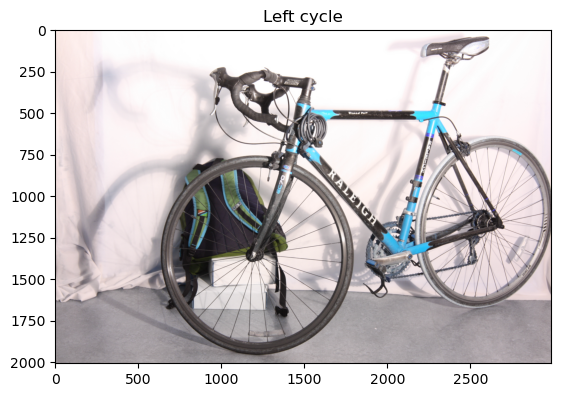

In [3]:
plt.imshow(left_bike)
plt.title("Left cycle")

Text(0.5, 1.0, 'Right cycle')

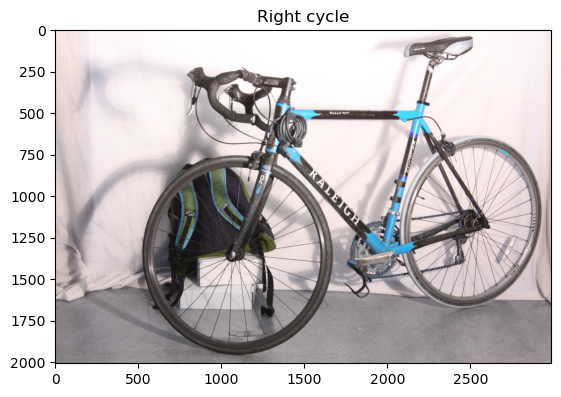

In [4]:
plt.imshow(right_bike)
plt.title("Right cycle")

Left and Right intrinsic matrix

In [5]:
left_Intrinsic = [[5299.313, 0, 1263.818],
      [0, 5299.313, 977.763],
      [0, 0, 1]]

right_Intrinsic = [[5299.313, 0, 1438.004],
      [0, 5299.313, 977.763], 
      [0, 0, 1]]

baseline = 177.288

Resize the image

In [7]:
inp_dim_x = 1200
inp_dim_y = 1200
right_bike = cv2.resize(right_bike, (inp_dim_x, inp_dim_y))
left_bike = cv2.resize(left_bike, (inp_dim_x, inp_dim_y))


Using SIFT for corresponding points

In [9]:
sift = cv2.SIFT_create()
gray_img_r = cv2.cvtColor(right_bike, cv2.COLOR_BGR2GRAY)
keypoints_r, descriptors_r = sift.detectAndCompute(gray_img_r, None)

In [10]:
sift = cv2.SIFT_create()
gray_img_l = cv2.cvtColor(left_bike, cv2.COLOR_BGR2GRAY)
keypoints_l, descriptors_l = sift.detectAndCompute(gray_img_l, None)

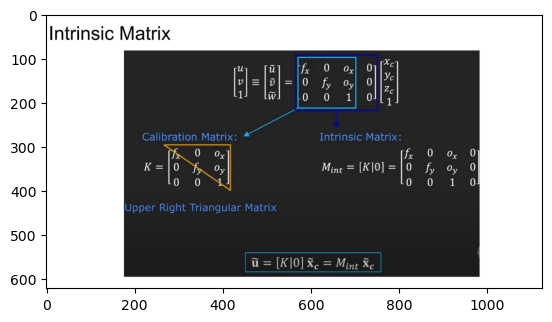

In [11]:
plt.imshow(cv2.imread("./Intrinsic.png", cv2.IMREAD_COLOR))

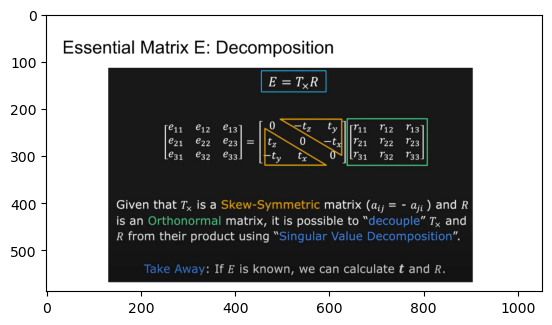

In [12]:
plt.imshow(cv2.imread("./Essential_matrix.png", cv2.IMREAD_COLOR))

Computing essential matrix

In [13]:
# In the question baseline is given which mean that the tx = baseline and ty = tz = 0 and also rotation matrix will be identity
# using this idea essential matrixs can be calculated using above formula

tx = baseline
ty, tz = 0, 0
translation_matrix = np.array([[0, -tz, ty],
                              [tz, 0, -tx],
                              [-ty, tx, 0]])
rotation_matrix = np.array([[1, 0, 0],
                            [0, 1, 0],
                            [0, 0, 1]])
essential_matrix = np.dot(translation_matrix,rotation_matrix)

print(essential_matrix)

[[   0.       0.       0.   ]
 [   0.       0.    -177.288]
 [   0.     177.288    0.   ]]


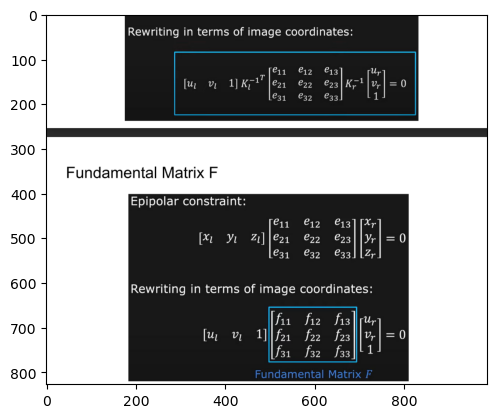

In [14]:
plt.imshow(cv2.imread("./fundamental.png", cv2.IMREAD_COLOR))

Compute the fundamental matrix

In [15]:
# using the above formula we can calculate the fundamental matrix
K_l_inv = np.linalg.inv(left_Intrinsic)
K_r_inv = np.linalg.inv(right_Intrinsic)
K_l_inv_transpose = K_l_inv.transpose()

fundamental_matrix = K_l_inv_transpose @ essential_matrix @ K_r_inv

print(fundamental_matrix)

[[ 0.         0.         0.       ]
 [ 0.         0.        -0.0334549]
 [ 0.         0.0334549  0.       ]]


In [16]:
def find_corresponding_point(x1, y1,fundamental_matrix, inp_dim_x, inp_dim_y):
    p1 = np.array([x1, y1, 1])  # Homogeneous coordinates
    # Compute the epipolar line in the second image
    epipolar_line = np.dot(fundamental_matrix, p1)

    # search_range =   # Example range (pixels)

    best_matching_point = None
    best_matching_sad = float('inf')
    half_window = 3
    # Ensure that slice indices are integers
    x1, y1, half_window = int(x1), int(y1), int(half_window)
    # Extract the window from the first image (right_bike)
    window1 = gray_img_r[y1 - half_window:y1 + half_window + 1, x1 - half_window:x1 + half_window + 1]

    # Search for the corresponding point along the epipolar line in the second image using SAD and descriptor matching
    for x2 in range(x1-5, x1+60):
        y2 = int((-epipolar_line[0] * x2 - epipolar_line[2]) / epipolar_line[1])  # Compute y coordinate from the line equation
        # Check if (x2, y2) is within the image boundaries
        if 0 <= x2 < inp_dim_x and 0 <= y2 < inp_dim_y:
            # Extract the window from the second image (left_bike)
            window2 = gray_img_l[y2 - half_window:y2 + half_window + 1, x2 - half_window:x2 + half_window + 1]
            if window2.shape != window1.shape:
                continue  

            # Compute SAD (Sum of Absolute Differences) between the windows
            sad_value = np.sum(np.abs(window1.astype(np.float32) - window2.astype(np.float32)))
            # Update best matching point if the SAD value is smaller
            if sad_value < best_matching_sad:
                best_matching_sad = sad_value
                best_matching_point = (x2, y2)

    # Output the best matching point and its SAD value
    if(best_matching_point == None):
        return (-1,-1)
    return best_matching_point

Checking for the accuracy of the corresponding points

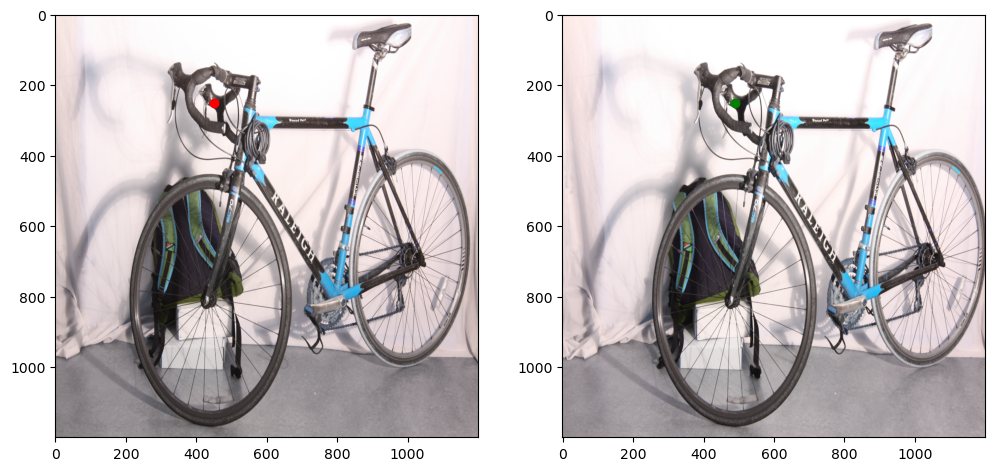

In [19]:
x1, y1 = 450, 250

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(right_bike)
axes[0].plot(x1,y1, "ro")

x2, y2 = find_corresponding_point(x1, y1,fundamental_matrix, inp_dim_x, inp_dim_y)
axes[1].imshow(left_bike)
axes[1].plot(x2,y2, "go")

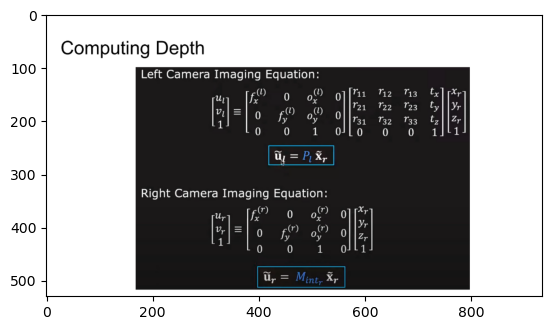

In [20]:
plt.imshow(cv2.imread("./P_l.png", cv2.IMREAD_COLOR))

Computing the P_L and M_r for 3d points calculation

In [22]:
rot_mat = np.array([[1, 0, 0, baseline],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])
L_intrinsic = [[5299.313, 0, 1263.818, 0],
                [0, 5299.313, 977.763, 0],
                [0, 0, 1, 0]]
P_L = np.dot(L_intrinsic, rot_mat)
P_L

array([[5.29931300e+03, 0.00000000e+00, 1.26381800e+03, 9.39504603e+05],
       [0.00000000e+00, 5.29931300e+03, 9.77763000e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [23]:
M_r = [[5299.313, 0, 1438.004, 0],
      [0, 5299.313, 977.763, 0], 
      [0, 0, 1, 0]]
M_r

[[5299.313, 0, 1438.004, 0], [0, 5299.313, 977.763, 0], [0, 0, 1, 0]]

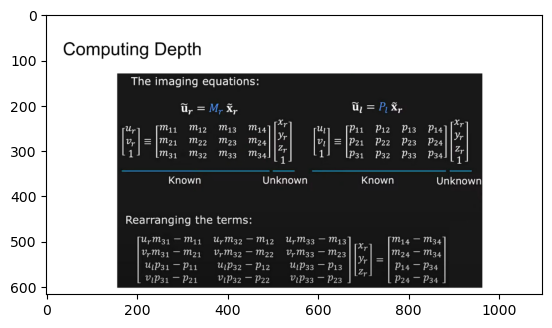

In [24]:
plt.imshow(cv2.imread("./Computing_dep.png", cv2.IMREAD_COLOR))

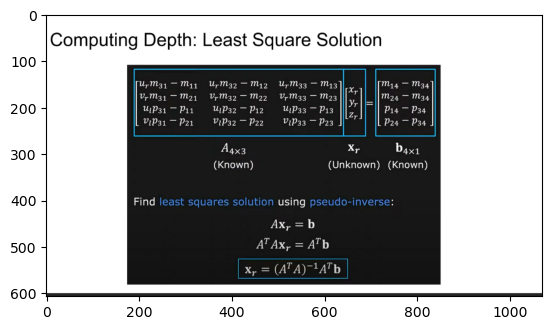

In [25]:
plt.imshow(cv2.imread("./L_s_sol.png", cv2.IMREAD_COLOR))

In [26]:
def compute_3d_point(u_l, u_r, v_l, v_r):
    A_matrix = np.array([[u_r*M_r[2][0] - M_r[0][0], u_r*M_r[2][1] - M_r[0][1], u_r*M_r[2][2] - M_r[0][2]],
                         [v_r*M_r[2][0] - M_r[1][0], v_r*M_r[2][1] - M_r[1][1], v_r*M_r[2][2] - M_r[1][2]],
                         [u_l*P_L[2][0] - P_L[0][0], u_l*P_L[2][1] - P_L[0][1], u_l*P_L[2][2] - P_L[0][2]],
                         [v_l*P_L[2][0] - P_L[1][0], v_l*P_L[2][1] - P_L[1][1], v_l*P_L[2][2] - P_L[1][2]]])
    
    B_matrix = np.array([[M_r[0][3] - M_r[2][3]],
                         [M_r[1][3] - M_r[2][3]],
                         [P_L[0][3] - P_L[2][3]],
                         [P_L[1][3] - P_L[2][3]]])
    
    X_3d = np.linalg.inv(A_matrix.transpose() @ A_matrix) @ (A_matrix.transpose()) @ B_matrix
    return X_3d

In [28]:
disparity_map = np.zeros_like(gray_img_l)
depth_map = np.zeros_like(gray_img_l)
point_3d_list = []
for i in range(inp_dim_x):
    cur_col = []
    for j in range(inp_dim_y):
        x2, y2 = find_corresponding_point(i, j,fundamental_matrix, inp_dim_x, inp_dim_y)
        point_3d = compute_3d_point(x2, i, y2, j)
        depth_map[i][j] = point_3d[2][0]
        disparity_map[i][j] = 1/(point_3d[2][0] + 1e-4)
        cur_col.append(point_3d)
    point_3d_list.append(cur_col)

Depth Map

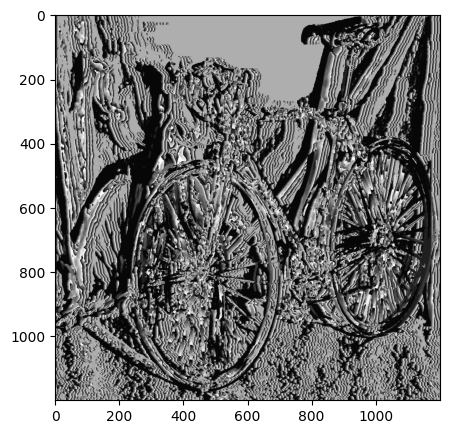

In [ ]:
plt.figure(figsize=(10,5))

rotated_disparity = np.transpose(depth_map)
normalized_mirror = cv2.normalize(rotated_disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

plt.imshow(normalized_mirror, cmap='gray')
plt.show()

Plotting the 3d point cloud

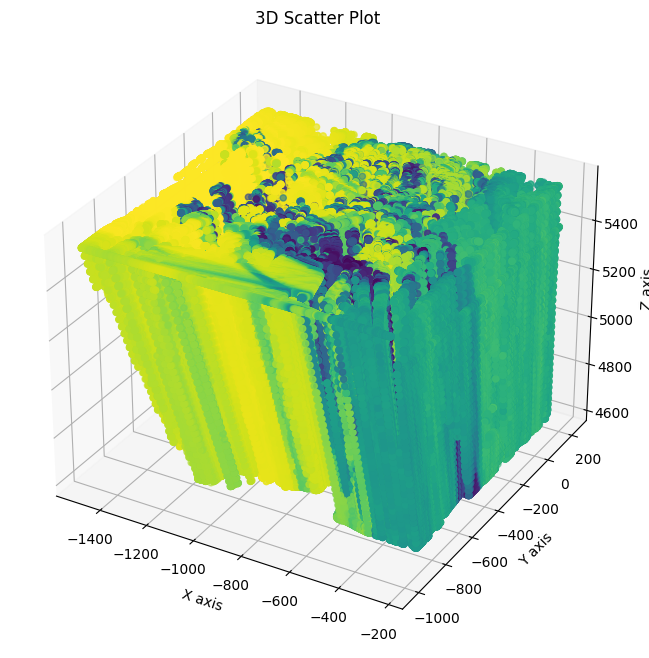

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points using Matplotlib's scatter
x = []
y = []
z = []
colors = []
for i in range(1200):
    for j in range(1200):
        # print(j)
        x.append(point_3d_list[i][j][0])
        y.append(point_3d_list[i][j][1])
        z.append(point_3d_list[i][j][2])
        colors.append(gray_img_l[i][j])
        # break

ax.scatter(x, y, z, c=colors )
# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()

Calculating the disparity Map

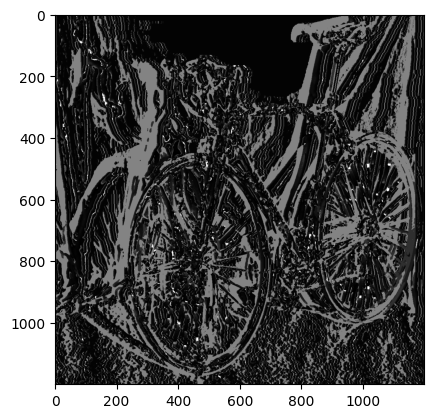

In [ ]:
disparity = (baseline * 5299.313) / (rotated_disparity)
normalized_mirror_dis = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

plt.imshow(normalized_mirror_dis, cmap='gray')
plt.show()